https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73

http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture13.pdf

https://www.youtube.com/watch?v=IQpP_cH8rrA

we can use perceptron to do vae


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.distributions import Normal
import numpy as np
import matplotlib.pyplot as plt 
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
import tqdm
from torchvision.utils import save_image, make_grid

In [ ]:
IMAGE_SIZE = 28
CHANNELS_IMG = 1
BATCH_SIZE = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x)),     
])

# CHANNELS_IMG = 1, because we use Mnist
train_dataset = datasets.MNIST(
    root="dataset/", train=True, transform=transform, download=True
)
# CHANNELS_IMG = 1, because we use Mnist
test_dataset = datasets.MNIST(
    root="dataset/", train=False, transform=transform, download=True
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [ ]:
train_dataset[0][0].shape # image 0, tensor at the position 0
print(train_loader.batch_size)

64


In [ ]:
# plt.imshow()

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, input_shape, latent_dim=128):
        super().__init__()
        self.encoder_l1 = nn.Linear(in_features=input_shape, out_features=latent_dim)
        self.encoder_l2 = nn.Linear(in_features=latent_dim, out_features=latent_dim)

        self.decoder_l1 = nn.Linear(in_features=latent_dim, out_features=latent_dim)
        self.decoder_l2 = nn.Linear(in_features=latent_dim, out_features=input_shape)
    
    def run_decoder(self, latent):
        output = F.relu(self.decoder_l1(latent))
        x_hat = F.relu(self.decoder_l2(output))
        return x_hat
        
    def run_encoder(self, x):
        output = F.relu(self.encoder_l1(x))
        latent = F.relu(self.encoder_l2(output))
        return latent 

    def forward(self, x):
        latent = self.run_encoder(x)
        x_hat = self.run_decoder(latent)
        return x_hat

In [ ]:
model = AutoEncoder(input_shape=IMAGE_SIZE*IMAGE_SIZE)
model.cuda()

AutoEncoder(
  (encoder_l1): Linear(in_features=784, out_features=128, bias=True)
  (encoder_l2): Linear(in_features=128, out_features=128, bias=True)
  (decoder_l1): Linear(in_features=128, out_features=128, bias=True)
  (decoder_l2): Linear(in_features=128, out_features=784, bias=True)
)

In [ ]:
model.train()

AutoEncoder(
  (encoder_l1): Linear(in_features=784, out_features=128, bias=True)
  (encoder_l2): Linear(in_features=128, out_features=128, bias=True)
  (decoder_l1): Linear(in_features=128, out_features=128, bias=True)
  (decoder_l2): Linear(in_features=128, out_features=784, bias=True)
)

In [ ]:
mse = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 100

for epoch in range(n_epochs):
    loss = 0
    for batch_idx, (batch_features, target) in enumerate(train_loader):
        batch_features = batch_features.cuda()
        optimizer.zero_grad()
        outputs = model(batch_features)
        train_loss = mse(outputs, batch_features)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    loss = loss/len(train_loader)
    if epoch %5 == 0:
        print("epochs : {}/{}, loss = {:.6f}".format(epoch+1, n_epochs, loss))



epochs : 1/100, loss = 0.010698
epochs : 6/100, loss = 0.010157
epochs : 6/100, loss = 0.010157
epochs : 11/100, loss = 0.009957
epochs : 11/100, loss = 0.009957
epochs : 16/100, loss = 0.009819
epochs : 16/100, loss = 0.009819
epochs : 21/100, loss = 0.009701
epochs : 21/100, loss = 0.009701
epochs : 26/100, loss = 0.009608
epochs : 26/100, loss = 0.009608
epochs : 31/100, loss = 0.009564
epochs : 31/100, loss = 0.009564
epochs : 36/100, loss = 0.009531
epochs : 36/100, loss = 0.009531
epochs : 41/100, loss = 0.009502
epochs : 41/100, loss = 0.009502
epochs : 46/100, loss = 0.009484
epochs : 46/100, loss = 0.009484
epochs : 51/100, loss = 0.009482
epochs : 51/100, loss = 0.009482
epochs : 56/100, loss = 0.009464
epochs : 56/100, loss = 0.009464
epochs : 61/100, loss = 0.009453
epochs : 61/100, loss = 0.009453
epochs : 66/100, loss = 0.009444
epochs : 66/100, loss = 0.009444
epochs : 71/100, loss = 0.009440
epochs : 71/100, loss = 0.009440
epochs : 76/100, loss = 0.009436
epochs : 76/1

In [ ]:
print("epochs : {}/{}, loss = {:.6f}".format(epoch+1, n_epochs, loss))

epochs : 100/100, loss = 0.009407


In [ ]:
# train_dataset[image_idx][1]

0

torch.Size([784])


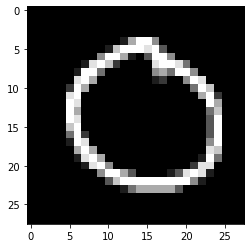

In [ ]:
model.eval()
image_idx = 68
image = train_dataset[image_idx][0].cuda()
x_hat = model(image)
print(x_hat.shape)
x_hat = x_hat.detach().cpu().numpy().reshape((28, 28))
plt.imshow(image.detach().cpu().numpy().reshape((28, 28)), cmap='gray')
# 

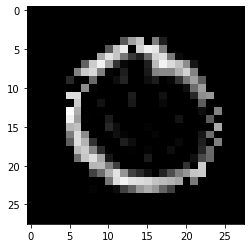

In [ ]:
plt.imshow(x_hat, cmap='gray')

Getting the latent representation space 

In [ ]:
def get_latent_representation(model, dataloader):
    latent_representation = []
    with torch.no_grad():
        for batch_idx, (batch_features, target) in enumerate(train_loader):
            batch_features = batch_features.cuda()
            latent = model.run_encoder(batch_features)
            latent = latent.cpu().numpy()
            latent_representation.append(latent)
        latent_representation = np.concatenate(latent_representation)
        return latent_representation

In [ ]:
latent = get_latent_representation(model, train_loader)
latent.shape

(60000, 128)

In [ ]:
# len(train_dataset)/len(train_loader)

63.96588486140725

<h1>Variational autoencoder</h1>

https://debuggercafe.com/convolutional-variational-autoencoder-in-pytorch-on-mnist-dataset/


In [ ]:
kernel_size = 4
init_channels = 8
image_channels = 1
latent_dim = 16

In [ ]:
class ConvVAE(nn.Module):
    def __init__(self, image_channels=1, kernel_size=4, latent_dim=16, init_channels=8):
        super(ConvVAE, self).__init__()
        self.enc1 = nn.Conv2d(
            in_channels=image_channels,
            out_channels = init_channels,
            kernel_size=kernel_size,
            stride=2,
            padding=1
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_channels,
            out_channels=init_channels*2,
            kernel_size=kernel_size,
            stride=2,
            padding=1
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_channels*2,
            out_channels=init_channels*4,
            kernel_size=kernel_size,
            stride=2,
            padding=1
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_channels*4,
            out_channels=64,
            kernel_size=kernel_size,
            stride=2,
            padding=0
        )
        self.fc1 = nn.Linear(64, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)

        # decoder
        self.dec1 = nn.ConvTranspose2d(
            in_channels=64,
            out_channels=init_channels*8,
            kernel_size=kernel_size,
            stride=1,
            padding=0
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_channels*8,
            out_channels=init_channels*4,
            kernel_size=kernel_size,
            stride=2,
            padding=1
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_channels*4,
            out_channels=init_channels*2,
            kernel_size=kernel_size,
            stride=2,
            padding=1
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_channels*2,
            out_channels=image_channels,
            kernel_size=kernel_size,
            stride=2,
            padding=1
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        sample = mu + (eps + std)
        return sample

    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        batch, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        hidden = self.fc1(x)
        mu = self.fc_mu(hidden)
        #get the latent vector through reparametarization
        log_var = self.fc_log_var(hidden)
        z = self.reparameterize(mu, log_var)
        z = self.fc2(z)
        z = z.view(-1, 64, 1, 1)
        # decoding
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))
        return reconstruction, mu, log_var


        

In [ ]:
!pip install imageio

In [ ]:
import imageio

def image_to_vid(images):
    imgs = [np.array(F.to_pil_image(img)) for img in images]
    imageio.mimsave('generated_image.gif', imgs)

def save_reconstructed_images(recon_images, epoch):
    save_image(recon_images.cpu(), f"{epoch}_.jpg")

def save_original_images(recon_images, epoch):
    save_image(recon_images.cpu(), f"{epoch}.jpg")

def final_loss(bce_loss, mu, logvar):
    BCE = bce_loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train(model, dataloader, dataset_size, device, optimizer, criterion):
    model.train()
    running_loss = 0.0
    counter = 0
    
    for i, data in tqdm.tqdm(enumerate(dataloader), total=int(dataset_size/dataloader.batch_size)):  
        counter += 1
        data = data[0]
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)

        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()

    train_loss = running_loss / counter
    return train_loss


def validate(model, dataloader, dataset, device, criterion):
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm.tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):  
            counter += 1
            data = data[0]
            data = data.to(device)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()

            # save the last batch input ad output of every epoch
            # if i == int(len(dataset)/len(dataloader)) -1 :
            if i == len(dataloader) - 1 :
                recon_images = reconstruction
                original_images = data
    val_loss = running_loss / counter
    return val_loss, recon_images, original_images

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = ConvVAE().to(device)
lr = 0.001
epochs = 50
batch_size = 64

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),   
])

# CHANNELS_IMG = 1, because we use Mnist
train_dataset = datasets.MNIST(
    root="dataset/", train=True, transform=transform, download=True
)
# CHANNELS_IMG = 1, because we use Mnist
test_dataset = datasets.MNIST(
    root="dataset/", train=False, transform=transform, download=True
)

trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,)

cuda


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=lr)

criterion = nn.BCELoss(reduction='sum')
grid_images = []
train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch + 1} of {epochs}")
    train_epoch_loss = train(
        model, trainloader, len(train_dataset), device, optimizer, criterion
    )
    valid_epoch_loss, recon_images, original_images = validate(
        model, testloader, test_dataset, device, criterion
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)

    #save the reconstructed image from the validation loop
    save_reconstructed_images(recon_images, epoch+1)
    save_original_images(original_images, epoch+1)
    image_grid = make_grid(recon_images.detach().cpu())
    grid_images.append(image_grid)
    print(f"Train loss:{train_epoch_loss:.4f}")
    print(f"Train loss:{valid_epoch_loss:.4f}")

with torch.no_grad():
    model.eval()
    torch.save(model.state_dict(), './model/model_vae_ok.ckpt')
    print('The best model is detected')

Epoch 1 of 50


938it [00:13, 68.70it/s]                         
157it [00:01, 95.66it/s]                         


Train loss:16348.1955
Train loss:13223.9973
Epoch 2 of 50


938it [00:13, 68.86it/s]                         
157it [00:01, 98.99it/s] 


Train loss:12681.3580
Train loss:12210.2501
Epoch 3 of 50


938it [00:14, 65.85it/s]                         
157it [00:01, 97.89it/s]                         


Train loss:12066.6032
Train loss:11777.2610
Epoch 4 of 50


 42%|████▏     | 395/937 [00:05<00:07, 68.44it/s]


KeyboardInterrupt: ignored